In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [92]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    err = y - y_pred
    se = err ** 2
    mse = se.mean()
    return np.sqrt(mse)

## Data Preparation

In [93]:
car = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
car.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [94]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = car[base].copy()
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


## Distribution of fuel

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

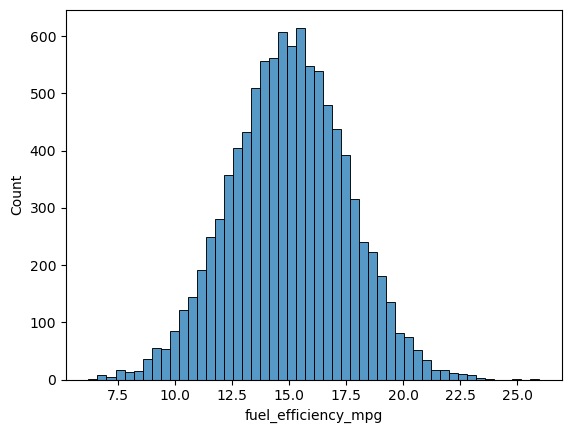

In [95]:
sns.histplot(df.fuel_efficiency_mpg, bins=50)

The distribution of the target variable `fuel_efficiency_mpg` looks like the normal distribution so no need the log transformation.

## Q1. Missing values

In [96]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

Column `horsepower` has missing values. 

## Q2. The Median of `horsepower`

In [97]:
median_horsepower = df.horsepower.median()
median_horsepower

149.0

## Setup the framework

In [98]:
n = len(df) 
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
n, n_val + n_test + n_train

(9704, 9704)

## Data partitioning

Split the data in train/val/test sets, with 60%/20%/20% distribution.

In [99]:
n_val, n_test, n_train

(1940, 1940, 5824)

## Data shuffling

Shuffle the dataset, I use seed `42`.

In [ ]:
# let's shuffle the records with index
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [85]:
df_train.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
246,170,164.0,2990.040917,2019,15.963019
8125,170,NaN,2729.623741,2012,15.931964
1927,200,142.0,3126.513375,2019,14.284901
8235,200,148.0,3136.477901,2003,14.865210
424,230,141.0,3384.681613,2006,12.428822


In [86]:
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

### Restating the index

In [87]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [88]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"] 
del df_test["fuel_efficiency_mpg"]

y_train

array([15.96301887, 15.93196432, 14.28490115, ..., 16.02876881,
       17.79420446, 18.04456134])

## Baseline model to predict `fuel_efficiency_mpg`

In [137]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
def prepare_X_0(df):
    df = df.copy()

    # df['age'] = 2020 - df.model_year
    # features = cols + ['age']

    df_num = df[cols]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [138]:
def prepare_X_mean(df):
    df = df.copy()

    horsepower_mean = df['horsepower'].mean()
    df['horsepower'] = df['horsepower'].fillna(horsepower_mean).values

    # df['age'] = 2020 - df.model_year
    # features = cols + ['age']

    df_num = df[cols]
    X = df_num.values
    return X

### With `0` for missing values

In [139]:
X_train = prepare_X_0(df_train)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
score_0 = rmse(y_train, y_pred)
score_0

0.5219709782195826

### With `mean` for missing values

In [140]:
X_train = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
score_mean = rmse(y_train, y_pred)
score_mean

0.4667165231665452

## Q3. Which options gives better RMSE? 

### Improve model with validation data set

In [141]:
X_train = prepare_X_0(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_0(df_val)
y_pred = w0 + X_val.dot(w)
score_0 = rmse(y_val, y_pred).round(2)
score_0

0.51

In [142]:
X_train = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_mean(df_val)
y_pred = w0 + X_val.dot(w)
score_mean = rmse(y_val, y_pred).round(2)
score_mean

0.46

The option with `mean` for missing values gives better RMSE.

## Q4. Best regularization parameter

In [143]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X_0(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X_0(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred).round(2)

    print(r, w0, score)

0 27.51385258061641 0.51
0.01 23.76399206918242 0.51
0.1 10.672729453776853 0.52
1 1.639727781710421 0.52
5 0.3443695413418393 0.52
10 0.1732727134160234 0.52
100 0.01743260384835424 0.52


The best regularization parameter is `0.01`.

## Q5. RMSE Standard Deviation 

In [144]:
all_scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values

    del df_train["fuel_efficiency_mpg"]
    del df_val["fuel_efficiency_mpg"] 
    del df_test["fuel_efficiency_mpg"]

    X_train = prepare_X_0(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X_0(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    all_scores.append(score)

    print(seed, w0, score)

0 27.37638874409174 0.5206531296292124
1 29.022468553091667 0.5213388912852299
2 25.904357608323043 0.5228069974611368
3 28.01545006731541 0.5159516741308033
4 25.93400040643806 0.510912946002077
5 25.899506959003144 0.528340646002021
6 25.917230936535436 0.5313910658148291
7 28.41432473350829 0.509067038740363
8 26.478417828266373 0.5147399129389566
9 27.51385258061641 0.5131865908212366


In [145]:
np.std(all_scores).round(3)

0.007

## Q6. Evaluation on test

In [147]:
np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"] 
del df_test["fuel_efficiency_mpg"]

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

X_full_train = prepare_X_0(df_full_train)

y_full_train = np.concatenate([y_train, y_val])
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

X_test = prepare_X_0(df_test)
y_pred = w0 + X_test.dot(w)
rmse(y_test, y_pred)

0.5156261299185413